# ***1. data preperation***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq

Downloading...
From (original): https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq
From (redirected): https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq&confirm=t&uuid=e67f6085-3561-4cb4-a41e-291ce25a8302
To: /content/D3_Ulcerative-Keratitis.zip
100% 839M/839M [00:10<00:00, 79.8MB/s]


In [ ]:
!unzip -qq /content/D3_Ulcerative-Keratitis.zip

# ***2.data preprocessing***

In [ ]:
# efficientnet 설치
!pip install torch torchvision torchaudio
!pip install efficientnet_pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import ImageFile
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from torch.utils.data import random_split

In [ ]:
# gpu 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# 시드고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 예시로 seed를 42로 설정
set_seed(42)

In [ ]:
# 데이터 경로 설정
data_path = "/content/D3_Ulcerative-Keratitis"
# 전처리 및 데이터 로드
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조절
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)

# 비율 설정
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# 데이터셋을 8:1:1 비율로 훈련, 검증, 테스트 세트로 분할
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 데이터 로더 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 라벨 가져오기
class_labels = dataset.classes

# 클래스 라벨 출력
print("클래스 라벨:", class_labels)

클래스 라벨: ['Mild', 'Severe', 'negative']


# ***2-1. image visualization***

- 이미지 출력하여 확인

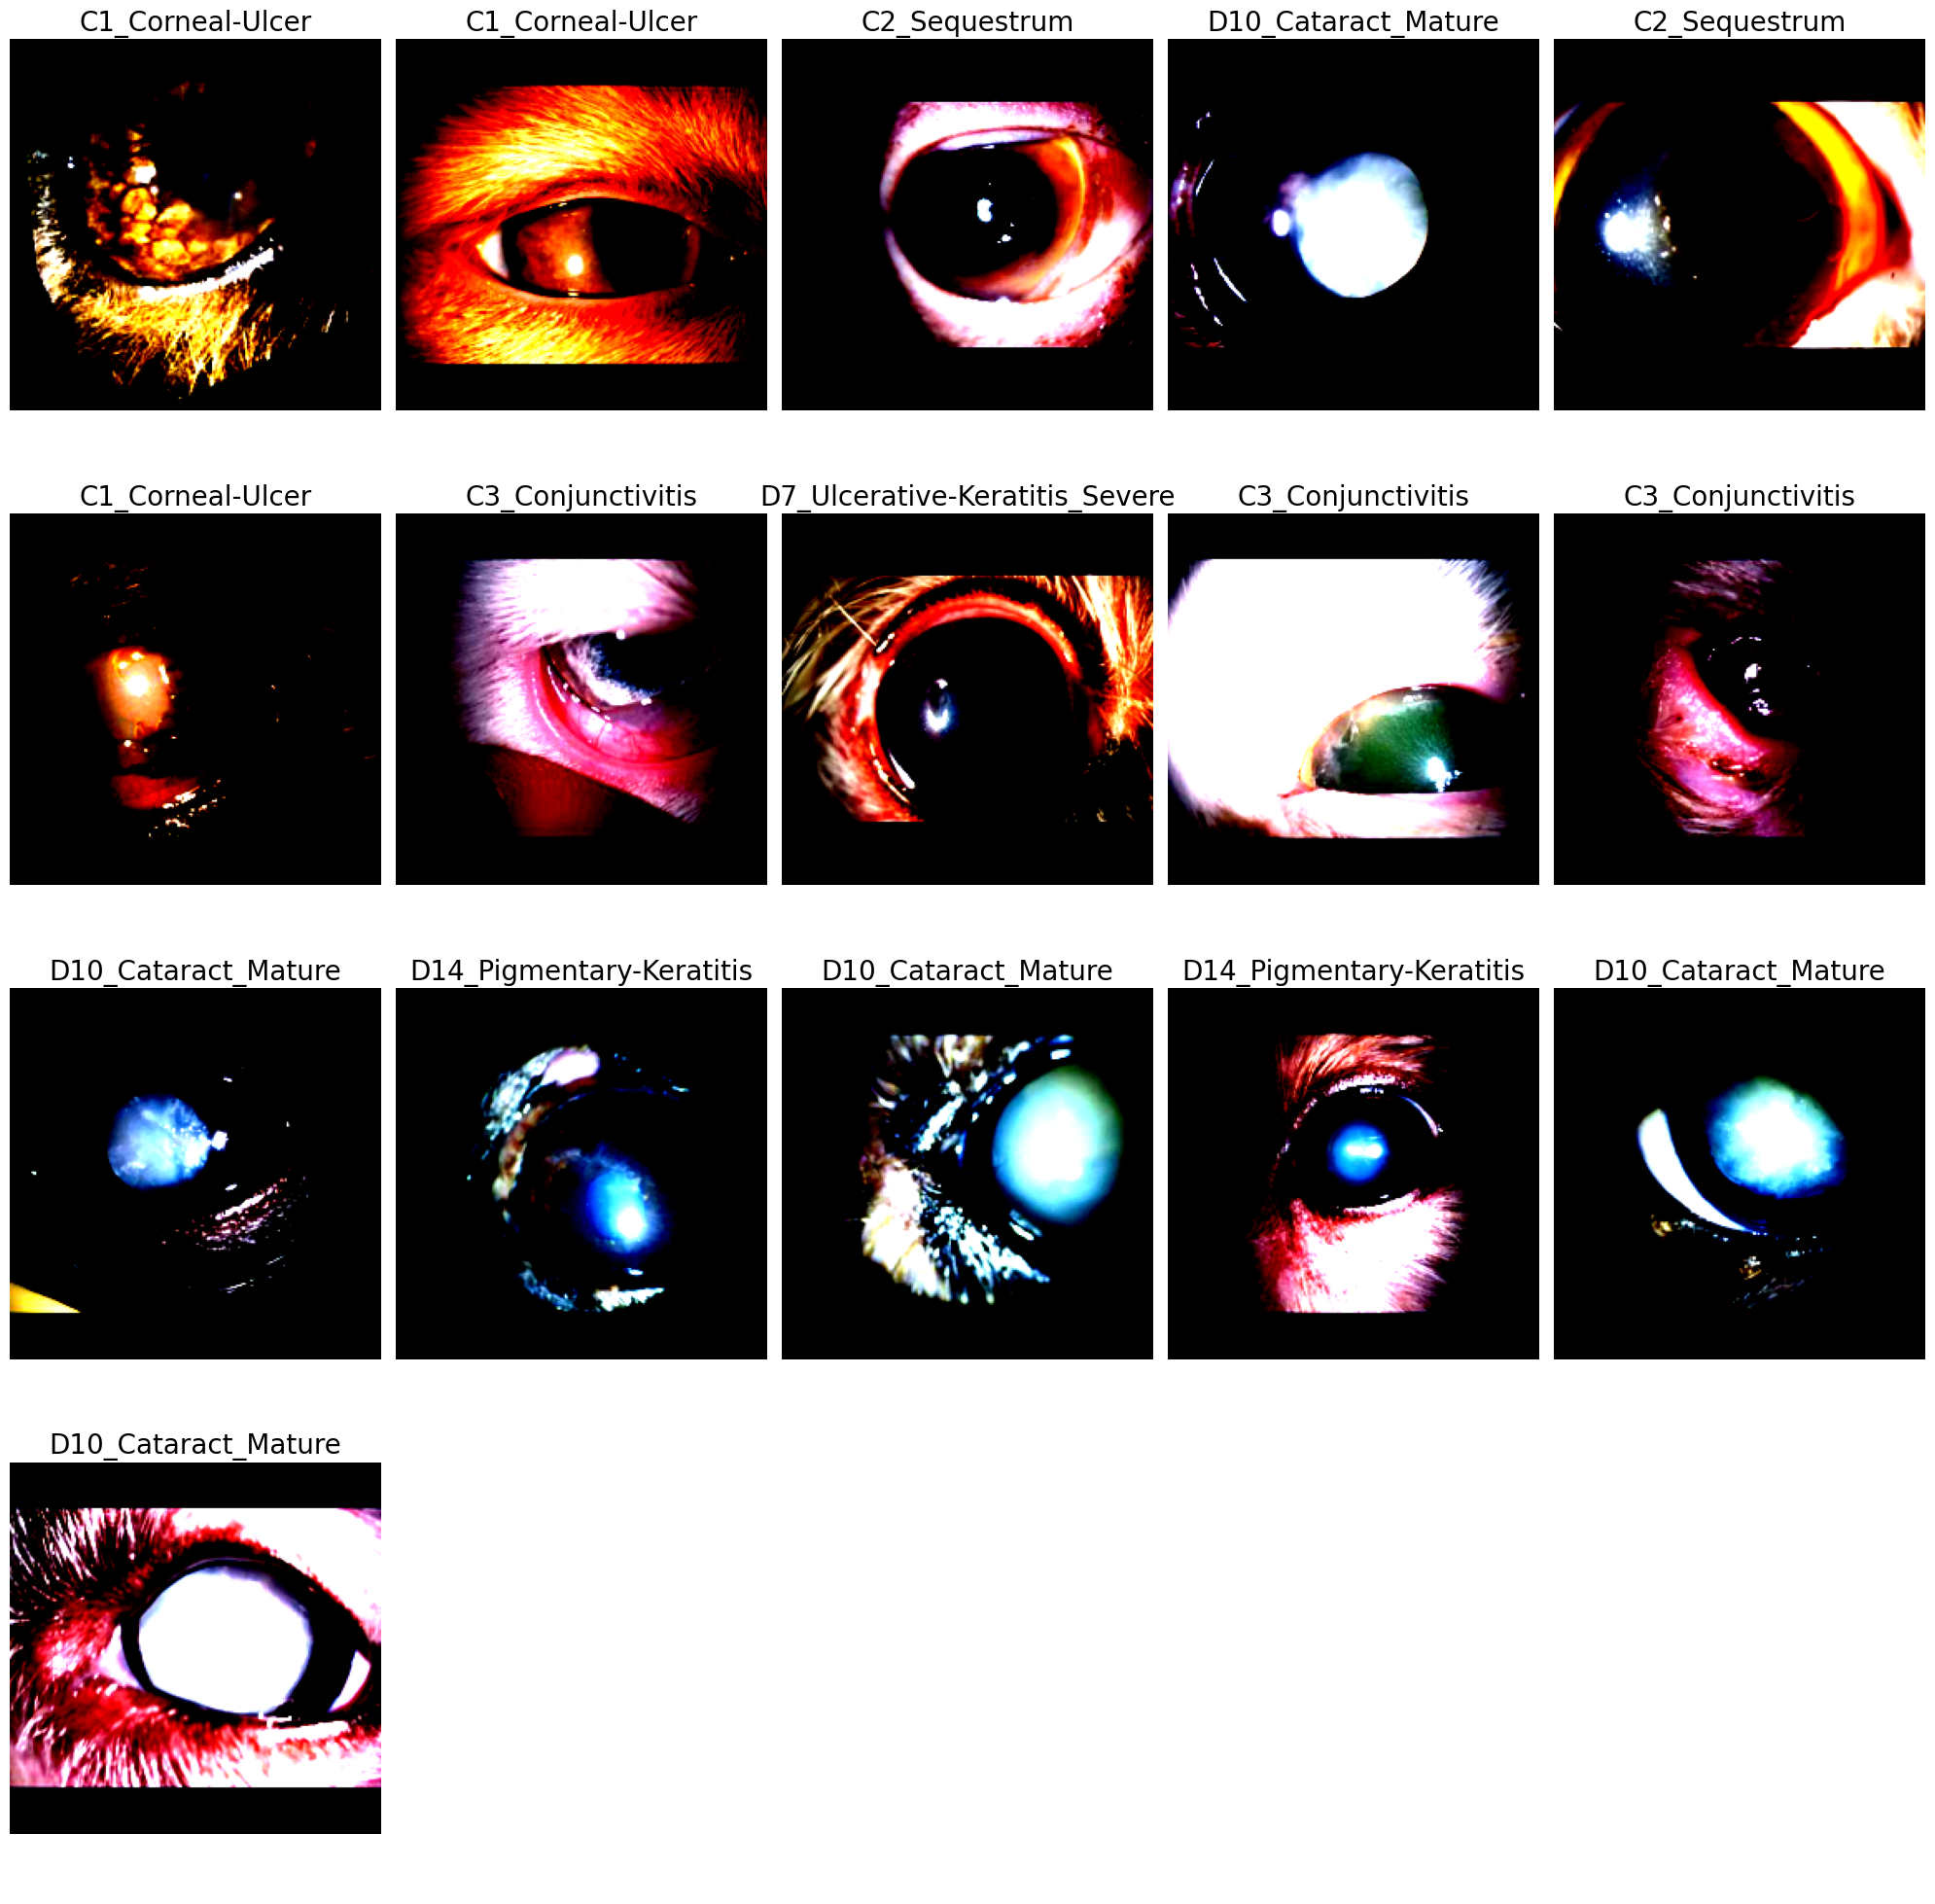

In [ ]:
# 데이터로더에서 이미지와 레이블 가져오기
images, labels = next(iter(train_loader))

# 클래스 인덱스와 클래스명 매핑
class_names = train_dataset.classes

# 이미지 확인을 위한 코드
num_images = len(images)
num_columns = 5  # 한 줄에 표시할 이미지 수

num_rows = (num_images + num_columns - 1) // num_columns  # 필요한 행 수 계산
fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))  # 플롯의 크기 조정

for i in range(num_images):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열

    image = images[i].permute(1, 2, 0)  # 이미지의 차원을 (H, W, C)로 변경
    image = np.clip(image, 0, 1)  # 이미지 값을 [0, 1] 범위로 클리핑합니다.

    axs[row, col].imshow(image)
    axs[row, col].set_title(class_names[labels[i].item()], fontsize=20)  # 클래스명 표시, 폰트 크기 조정
    axs[row, col].axis('off')

# 남은 공간에 빈 플롯 생성
for i in range(num_images, num_rows * num_columns):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열
    axs[row, col].axis('off')

plt.tight_layout()  # 레이아웃 조정
plt.show()


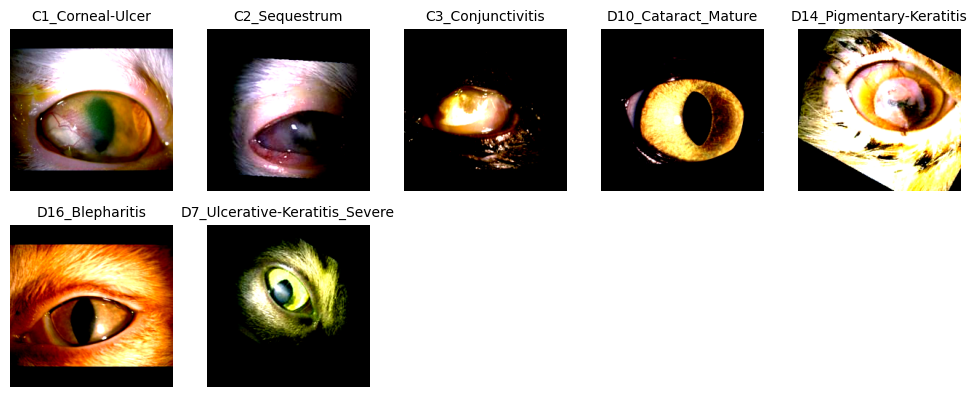

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주는 함수 정의
def imshow(image):
    image = image / 2 + 0.5  # 이미지를 정규화된 형태에서 복원
    image = np.clip(image, 0, 1)  # 이미지 값을 [0, 1] 범위로 클립합니다.
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))  # 이미지의 차원을 변경하여 출력
    plt.axis('off')

# 각 클래스의 이미지를 4x5 형태로 출력
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    class_index = train_dataset.class_to_idx[class_names[i]]
    image, _ = train_dataset[class_index]
    plt.subplot(4, 5, i+1)
    plt.title(class_names[i], fontsize=10)  # 폰트 크기 조정
    imshow(image)
plt.tight_layout()
plt.show()


# ***3. model load 및 parameter***

In [ ]:
from efficientnet_pytorch import EfficientNet

# 모델 초기화
num_classes = len(dataset.classes)
model = EfficientNet.from_pretrained('efficientnet-b5')

# EfficientNet 모델의 분류기 변경
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)

# 드롭아웃 레이어 추가
model._dropout = nn.Dropout(0.5)  # 드롭아웃 확률 조정

# 모델 출력
print(model)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 508MB/s] 


Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

# ***4. criterion & optimizer***

In [ ]:
import torch.optim as optim

# 손실 함수 및 Adam 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=0.01)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# Transfer Learning
ct = 0
for child in model.children():  # model.children() -> 모델의 layer정보
  ct += 1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

# ***5. model training***

In [ ]:
# 배치 수 확인
total_batch = len(train_loader)
print(total_batch) # 516

516


In [ ]:
# 얼리스탑
def early_stopping(val_loss_history, patience=5):
    if len(val_loss_history) < patience + 1:
        return False
    else:
        if all(val_loss_history[-1] >= val_loss_history[-patience-1:]):
            return True
        else:
            return False

# 모델 훈련
def train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)

    # 훈련 중간 결과 저장할 딕셔너리 초기화
    results = {
        'epoch_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'train_loss': [],
        'train_accuracy': []
    }

    try:
        val_loss_history = []
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # 에폭 시작 시간 기록

            # Training
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader.dataset)
            train_accuracy = correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            predictions = []
            targets = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += criterion(outputs, labels).item() * inputs.size(0)
                    predictions.extend(predicted.cpu().numpy())
                    targets.extend(labels.cpu().numpy())

            val_accuracy = correct / total
            val_loss = val_loss / len(val_loader.dataset)
            val_precision = precision_score(targets, predictions, average='weighted')
            val_recall = recall_score(targets, predictions, average='weighted')
            val_f1 = f1_score(targets, predictions, average='weighted')

            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}, Time: {time.time() - epoch_start_time:.0f}s")

            # 중간 결과 저장
            results['epoch_loss'].append(train_loss)
            results['val_loss'].append(val_loss)
            results['val_accuracy'].append(val_accuracy)
            results['val_precision'].append(val_precision)
            results['val_recall'].append(val_recall)
            results['val_f1'].append(val_f1)
            results['train_loss'].append(train_loss)
            results['train_accuracy'].append(train_accuracy)

            # Early Stopping 체크
            if early_stopping(val_loss_history, patience=5):
                print("Early stopping!")
                break
    except Exception as e:
        print(f"An error occurred during training: {str(e)}")

    # best 에폭 찾기
    best_epoch = np.argmax(results['val_accuracy'])
    best_accuracy = results['val_accuracy'][best_epoch]
    print(f"Best Validation Accuracy: {best_accuracy:.4f} at Epoch {best_epoch+1}")

    # 해당 에폭의 모델 저장
    best_model = model
    torch.save(best_model.state_dict(), 'best_model.pth')

    return results, best_model

# 모델 학습
results, best_model = train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 1/50, Train Loss: 1.0635, Train Accuracy: 0.4430
Epoch 1/50, Validation Loss: 1.0166, Validation Accuracy: 0.5994, Validation Precision: 0.5806, Validation Recall: 0.5994, Validation F1 Score: 0.5806, Time: 155s


Epoch 2/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 2/50, Train Loss: 0.9822, Train Accuracy: 0.5886
Epoch 2/50, Validation Loss: 0.9450, Validation Accuracy: 0.6867, Validation Precision: 0.6715, Validation Recall: 0.6867, Validation F1 Score: 0.6538, Time: 154s


Epoch 3/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 3/50, Train Loss: 0.9153, Train Accuracy: 0.6518
Epoch 3/50, Validation Loss: 0.8869, Validation Accuracy: 0.7197, Validation Precision: 0.7211, Validation Recall: 0.7197, Validation F1 Score: 0.6844, Time: 154s


Epoch 4/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 4/50, Train Loss: 0.8613, Train Accuracy: 0.6873
Epoch 4/50, Validation Loss: 0.8395, Validation Accuracy: 0.7299, Validation Precision: 0.7378, Validation Recall: 0.7299, Validation F1 Score: 0.6943, Time: 154s


Epoch 5/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 5/50, Train Loss: 0.8167, Train Accuracy: 0.7092
Epoch 5/50, Validation Loss: 0.7971, Validation Accuracy: 0.7405, Validation Precision: 0.7515, Validation Recall: 0.7405, Validation F1 Score: 0.7074, Time: 154s


Epoch 6/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 6/50, Train Loss: 0.7814, Train Accuracy: 0.7176
Epoch 6/50, Validation Loss: 0.7647, Validation Accuracy: 0.7483, Validation Precision: 0.7602, Validation Recall: 0.7483, Validation F1 Score: 0.7173, Time: 154s


Epoch 7/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 7/50, Train Loss: 0.7522, Train Accuracy: 0.7256
Epoch 7/50, Validation Loss: 0.7363, Validation Accuracy: 0.7507, Validation Precision: 0.7622, Validation Recall: 0.7507, Validation F1 Score: 0.7210, Time: 154s


Epoch 8/50: 100%|██████████| 516/516 [02:16<00:00,  3.77it/s]


Epoch 8/50, Train Loss: 0.7272, Train Accuracy: 0.7300
Epoch 8/50, Validation Loss: 0.7115, Validation Accuracy: 0.7498, Validation Precision: 0.7619, Validation Recall: 0.7498, Validation F1 Score: 0.7201, Time: 153s


Epoch 9/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 9/50, Train Loss: 0.7061, Train Accuracy: 0.7362
Epoch 9/50, Validation Loss: 0.6913, Validation Accuracy: 0.7561, Validation Precision: 0.7674, Validation Recall: 0.7561, Validation F1 Score: 0.7285, Time: 154s


Epoch 10/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 10/50, Train Loss: 0.6868, Train Accuracy: 0.7399
Epoch 10/50, Validation Loss: 0.6720, Validation Accuracy: 0.7565, Validation Precision: 0.7659, Validation Recall: 0.7565, Validation F1 Score: 0.7306, Time: 154s


Epoch 11/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 11/50, Train Loss: 0.6695, Train Accuracy: 0.7425
Epoch 11/50, Validation Loss: 0.6557, Validation Accuracy: 0.7575, Validation Precision: 0.7664, Validation Recall: 0.7575, Validation F1 Score: 0.7322, Time: 154s


Epoch 12/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 12/50, Train Loss: 0.6559, Train Accuracy: 0.7459
Epoch 12/50, Validation Loss: 0.6411, Validation Accuracy: 0.7609, Validation Precision: 0.7694, Validation Recall: 0.7609, Validation F1 Score: 0.7368, Time: 154s


Epoch 13/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 13/50, Train Loss: 0.6418, Train Accuracy: 0.7502
Epoch 13/50, Validation Loss: 0.6286, Validation Accuracy: 0.7648, Validation Precision: 0.7727, Validation Recall: 0.7648, Validation F1 Score: 0.7420, Time: 154s


Epoch 14/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 14/50, Train Loss: 0.6326, Train Accuracy: 0.7533
Epoch 14/50, Validation Loss: 0.6175, Validation Accuracy: 0.7662, Validation Precision: 0.7754, Validation Recall: 0.7662, Validation F1 Score: 0.7431, Time: 154s


Epoch 15/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 15/50, Train Loss: 0.6223, Train Accuracy: 0.7542
Epoch 15/50, Validation Loss: 0.6055, Validation Accuracy: 0.7648, Validation Precision: 0.7721, Validation Recall: 0.7648, Validation F1 Score: 0.7424, Time: 154s


Epoch 16/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 16/50, Train Loss: 0.6153, Train Accuracy: 0.7573
Epoch 16/50, Validation Loss: 0.5978, Validation Accuracy: 0.7682, Validation Precision: 0.7770, Validation Recall: 0.7682, Validation F1 Score: 0.7454, Time: 155s


Epoch 17/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 17/50, Train Loss: 0.6046, Train Accuracy: 0.7585
Epoch 17/50, Validation Loss: 0.5889, Validation Accuracy: 0.7687, Validation Precision: 0.7763, Validation Recall: 0.7687, Validation F1 Score: 0.7469, Time: 155s


Epoch 18/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 18/50, Train Loss: 0.5986, Train Accuracy: 0.7593
Epoch 18/50, Validation Loss: 0.5804, Validation Accuracy: 0.7716, Validation Precision: 0.7799, Validation Recall: 0.7716, Validation F1 Score: 0.7502, Time: 155s


Epoch 19/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 19/50, Train Loss: 0.5908, Train Accuracy: 0.7641
Epoch 19/50, Validation Loss: 0.5749, Validation Accuracy: 0.7745, Validation Precision: 0.7828, Validation Recall: 0.7745, Validation F1 Score: 0.7540, Time: 154s


Epoch 20/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 20/50, Train Loss: 0.5848, Train Accuracy: 0.7638
Epoch 20/50, Validation Loss: 0.5666, Validation Accuracy: 0.7759, Validation Precision: 0.7836, Validation Recall: 0.7759, Validation F1 Score: 0.7562, Time: 154s


Epoch 21/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 21/50, Train Loss: 0.5801, Train Accuracy: 0.7683
Epoch 21/50, Validation Loss: 0.5601, Validation Accuracy: 0.7755, Validation Precision: 0.7811, Validation Recall: 0.7755, Validation F1 Score: 0.7566, Time: 154s


Epoch 22/50: 100%|██████████| 516/516 [02:16<00:00,  3.77it/s]


Epoch 22/50, Train Loss: 0.5736, Train Accuracy: 0.7690
Epoch 22/50, Validation Loss: 0.5556, Validation Accuracy: 0.7779, Validation Precision: 0.7854, Validation Recall: 0.7779, Validation F1 Score: 0.7586, Time: 153s


Epoch 23/50: 100%|██████████| 516/516 [02:16<00:00,  3.78it/s]


Epoch 23/50, Train Loss: 0.5683, Train Accuracy: 0.7692
Epoch 23/50, Validation Loss: 0.5499, Validation Accuracy: 0.7818, Validation Precision: 0.7894, Validation Recall: 0.7818, Validation F1 Score: 0.7634, Time: 153s


Epoch 24/50: 100%|██████████| 516/516 [02:16<00:00,  3.77it/s]


Epoch 24/50, Train Loss: 0.5683, Train Accuracy: 0.7678
Epoch 24/50, Validation Loss: 0.5456, Validation Accuracy: 0.7842, Validation Precision: 0.7925, Validation Recall: 0.7842, Validation F1 Score: 0.7661, Time: 153s


Epoch 25/50: 100%|██████████| 516/516 [02:16<00:00,  3.77it/s]


Epoch 25/50, Train Loss: 0.5594, Train Accuracy: 0.7718
Epoch 25/50, Validation Loss: 0.5424, Validation Accuracy: 0.7808, Validation Precision: 0.7892, Validation Recall: 0.7808, Validation F1 Score: 0.7619, Time: 154s


Epoch 26/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 26/50, Train Loss: 0.5539, Train Accuracy: 0.7740
Epoch 26/50, Validation Loss: 0.5355, Validation Accuracy: 0.7856, Validation Precision: 0.7937, Validation Recall: 0.7856, Validation F1 Score: 0.7680, Time: 154s


Epoch 27/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 27/50, Train Loss: 0.5531, Train Accuracy: 0.7719
Epoch 27/50, Validation Loss: 0.5314, Validation Accuracy: 0.7842, Validation Precision: 0.7940, Validation Recall: 0.7842, Validation F1 Score: 0.7653, Time: 154s


Epoch 28/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 28/50, Train Loss: 0.5477, Train Accuracy: 0.7776
Epoch 28/50, Validation Loss: 0.5291, Validation Accuracy: 0.7832, Validation Precision: 0.7909, Validation Recall: 0.7832, Validation F1 Score: 0.7658, Time: 154s


Epoch 29/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 29/50, Train Loss: 0.5442, Train Accuracy: 0.7779
Epoch 29/50, Validation Loss: 0.5252, Validation Accuracy: 0.7866, Validation Precision: 0.7937, Validation Recall: 0.7866, Validation F1 Score: 0.7694, Time: 154s


Epoch 30/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 30/50, Train Loss: 0.5370, Train Accuracy: 0.7795
Epoch 30/50, Validation Loss: 0.5213, Validation Accuracy: 0.7876, Validation Precision: 0.7959, Validation Recall: 0.7876, Validation F1 Score: 0.7704, Time: 154s


Epoch 31/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 31/50, Train Loss: 0.5414, Train Accuracy: 0.7793
Epoch 31/50, Validation Loss: 0.5176, Validation Accuracy: 0.7886, Validation Precision: 0.7948, Validation Recall: 0.7886, Validation F1 Score: 0.7729, Time: 154s


Epoch 32/50: 100%|██████████| 516/516 [02:16<00:00,  3.77it/s]


Epoch 32/50, Train Loss: 0.5343, Train Accuracy: 0.7837
Epoch 32/50, Validation Loss: 0.5158, Validation Accuracy: 0.7890, Validation Precision: 0.7956, Validation Recall: 0.7890, Validation F1 Score: 0.7732, Time: 153s


Epoch 33/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 33/50, Train Loss: 0.5312, Train Accuracy: 0.7816
Epoch 33/50, Validation Loss: 0.5120, Validation Accuracy: 0.7895, Validation Precision: 0.7962, Validation Recall: 0.7895, Validation F1 Score: 0.7740, Time: 155s


Epoch 34/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 34/50, Train Loss: 0.5301, Train Accuracy: 0.7841
Epoch 34/50, Validation Loss: 0.5093, Validation Accuracy: 0.7900, Validation Precision: 0.7974, Validation Recall: 0.7900, Validation F1 Score: 0.7739, Time: 155s


Epoch 35/50: 100%|██████████| 516/516 [02:18<00:00,  3.74it/s]


Epoch 35/50, Train Loss: 0.5304, Train Accuracy: 0.7812
Epoch 35/50, Validation Loss: 0.5066, Validation Accuracy: 0.7905, Validation Precision: 0.7959, Validation Recall: 0.7905, Validation F1 Score: 0.7755, Time: 155s


Epoch 36/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 36/50, Train Loss: 0.5301, Train Accuracy: 0.7769
Epoch 36/50, Validation Loss: 0.5047, Validation Accuracy: 0.7924, Validation Precision: 0.7982, Validation Recall: 0.7924, Validation F1 Score: 0.7775, Time: 155s


Epoch 37/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 37/50, Train Loss: 0.5208, Train Accuracy: 0.7875
Epoch 37/50, Validation Loss: 0.5026, Validation Accuracy: 0.7929, Validation Precision: 0.7979, Validation Recall: 0.7929, Validation F1 Score: 0.7787, Time: 155s


Epoch 38/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 38/50, Train Loss: 0.5201, Train Accuracy: 0.7881
Epoch 38/50, Validation Loss: 0.4999, Validation Accuracy: 0.7934, Validation Precision: 0.7991, Validation Recall: 0.7934, Validation F1 Score: 0.7789, Time: 155s


Epoch 39/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 39/50, Train Loss: 0.5198, Train Accuracy: 0.7860
Epoch 39/50, Validation Loss: 0.4972, Validation Accuracy: 0.7963, Validation Precision: 0.8018, Validation Recall: 0.7963, Validation F1 Score: 0.7823, Time: 155s


Epoch 40/50: 100%|██████████| 516/516 [02:18<00:00,  3.73it/s]


Epoch 40/50, Train Loss: 0.5163, Train Accuracy: 0.7869
Epoch 40/50, Validation Loss: 0.4951, Validation Accuracy: 0.7992, Validation Precision: 0.8046, Validation Recall: 0.7992, Validation F1 Score: 0.7861, Time: 155s


Epoch 41/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 41/50, Train Loss: 0.5156, Train Accuracy: 0.7904
Epoch 41/50, Validation Loss: 0.4926, Validation Accuracy: 0.8016, Validation Precision: 0.8078, Validation Recall: 0.8016, Validation F1 Score: 0.7886, Time: 154s


Epoch 42/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 42/50, Train Loss: 0.5165, Train Accuracy: 0.7901
Epoch 42/50, Validation Loss: 0.4915, Validation Accuracy: 0.8016, Validation Precision: 0.8079, Validation Recall: 0.8016, Validation F1 Score: 0.7883, Time: 154s


Epoch 43/50: 100%|██████████| 516/516 [02:17<00:00,  3.74it/s]


Epoch 43/50, Train Loss: 0.5120, Train Accuracy: 0.7927
Epoch 43/50, Validation Loss: 0.4881, Validation Accuracy: 0.8007, Validation Precision: 0.8065, Validation Recall: 0.8007, Validation F1 Score: 0.7878, Time: 154s


Epoch 44/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 44/50, Train Loss: 0.5115, Train Accuracy: 0.7893
Epoch 44/50, Validation Loss: 0.4863, Validation Accuracy: 0.8036, Validation Precision: 0.8089, Validation Recall: 0.8036, Validation F1 Score: 0.7914, Time: 154s


Epoch 45/50: 100%|██████████| 516/516 [02:17<00:00,  3.75it/s]


Epoch 45/50, Train Loss: 0.5054, Train Accuracy: 0.7917
Epoch 45/50, Validation Loss: 0.4848, Validation Accuracy: 0.8046, Validation Precision: 0.8093, Validation Recall: 0.8046, Validation F1 Score: 0.7925, Time: 154s


Epoch 46/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 46/50, Train Loss: 0.5097, Train Accuracy: 0.7908
Epoch 46/50, Validation Loss: 0.4834, Validation Accuracy: 0.8031, Validation Precision: 0.8087, Validation Recall: 0.8031, Validation F1 Score: 0.7906, Time: 154s


Epoch 47/50: 100%|██████████| 516/516 [02:16<00:00,  3.78it/s]


Epoch 47/50, Train Loss: 0.5079, Train Accuracy: 0.7904
Epoch 47/50, Validation Loss: 0.4826, Validation Accuracy: 0.8021, Validation Precision: 0.8072, Validation Recall: 0.8021, Validation F1 Score: 0.7895, Time: 153s


Epoch 48/50: 100%|██████████| 516/516 [02:16<00:00,  3.78it/s]


Epoch 48/50, Train Loss: 0.5081, Train Accuracy: 0.7900
Epoch 48/50, Validation Loss: 0.4791, Validation Accuracy: 0.8031, Validation Precision: 0.8079, Validation Recall: 0.8031, Validation F1 Score: 0.7910, Time: 153s


Epoch 49/50: 100%|██████████| 516/516 [02:16<00:00,  3.78it/s]


Epoch 49/50, Train Loss: 0.5051, Train Accuracy: 0.7915
Epoch 49/50, Validation Loss: 0.4780, Validation Accuracy: 0.8070, Validation Precision: 0.8119, Validation Recall: 0.8070, Validation F1 Score: 0.7954, Time: 153s


Epoch 50/50: 100%|██████████| 516/516 [02:17<00:00,  3.76it/s]


Epoch 50/50, Train Loss: 0.5012, Train Accuracy: 0.7896
Epoch 50/50, Validation Loss: 0.4759, Validation Accuracy: 0.8050, Validation Precision: 0.8089, Validation Recall: 0.8050, Validation F1 Score: 0.7937, Time: 154s
Best Validation Accuracy: 0.8070 at Epoch 49


In [ ]:
# 메모리 관리
# # # 모델 삭제
# del model

# # # 캐시 삭제
# torch.cuda.empty_cache()

# # GPU 메모리 사용량 확인
# print(f'GPU 메모리 사용량: {torch.cuda.memory_allocated() / (1024**3):.2f} GB')

# ***6. model save***

In [ ]:
# 모델 자체를 저장

PATH = '/content/drive/MyDrive/D3_efficientnet_b5.pth'
torch.save(model, PATH) # 해당 path에 모델을 저장

In [ ]:
import pandas as pd

# 훈련 결과를 DataFrame으로 변환
results_df = pd.DataFrame({
    'Epoch': range(1, len(results['epoch_loss']) + 1),
    'Train Loss': results['train_loss'],
    'Train Accuracy': results['train_accuracy'],
    'Validation Loss': results['val_loss'],
    'Validation Accuracy': results['val_accuracy'],
    'Validation Precision': results['val_precision'],
    'Validation Recall': results['val_recall'],
    'Validation F1 Score': results['val_f1']
})

# DataFrame을 스타일링해서 출력
results_df_styled = results_df.style.format(precision=4).set_table_styles(
    [{'selector': 'thead th', 'props': [('font-weight', 'bold')]}]
).set_properties(**{'text-align': 'center'})

# display 함수로 출력
from IPython.display import display
display(results_df_styled)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score
0,1,1.0635,0.4430,1.0166,0.5994,0.5806,0.5994,0.5806
1,2,0.9822,0.5886,0.9450,0.6867,0.6715,0.6867,0.6538
2,3,0.9153,0.6518,0.8869,0.7197,0.7211,0.7197,0.6844
3,4,0.8613,0.6873,0.8395,0.7299,0.7378,0.7299,0.6943
4,5,0.8167,0.7092,0.7971,0.7405,0.7515,0.7405,0.7074
5,6,0.7814,0.7176,0.7647,0.7483,0.7602,0.7483,0.7173
6,7,0.7522,0.7256,0.7363,0.7507,0.7622,0.7507,0.7210
7,8,0.7272,0.7300,0.7115,0.7498,0.7619,0.7498,0.7201
8,9,0.7061,0.7362,0.6913,0.7561,0.7674,0.7561,0.7285
9,10,0.6868,0.7399,0.6720,0.7565,0.7659,0.7565,0.7306


loss visualization***

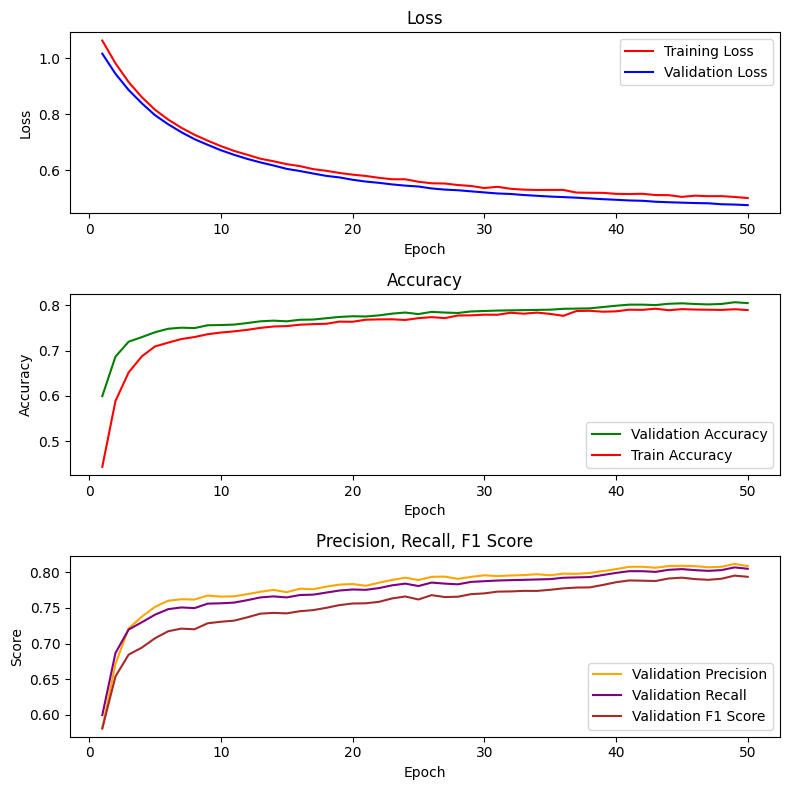

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(results):
    num_epochs = len(results['epoch_loss'])
    epochs = range(1, num_epochs + 1)

    # Loss 그래프
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))

    axes[0].plot(epochs, results['epoch_loss'], label='Training Loss', color='red')
    axes[0].plot(epochs, results['val_loss'], label='Validation Loss', color='blue')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy 그래프
    axes[1].plot(epochs, results['val_accuracy'], label='Validation Accuracy', color='green')
    axes[1].plot(epochs, results['train_accuracy'], label='Train Accuracy', color='red')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Precision, Recall, F1 Score 그래프
    axes[2].plot(epochs, results['val_precision'], label='Validation Precision', color='orange')
    axes[2].plot(epochs, results['val_recall'], label='Validation Recall', color='purple')
    axes[2].plot(epochs, results['val_f1'], label='Validation F1 Score', color='brown')
    axes[2].set_title('Precision, Recall, F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Score')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 학습 결과 시각화
plot_training_history(results)


# ***7. model test***

In [ ]:
# best 모델 불러오기
best_model = EfficientNet.from_name('efficientnet-b5', num_classes=num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

# 테스트 데이터셋으로 평가
correct = 0
total = 0
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8594


# ***8. confusion matrix***

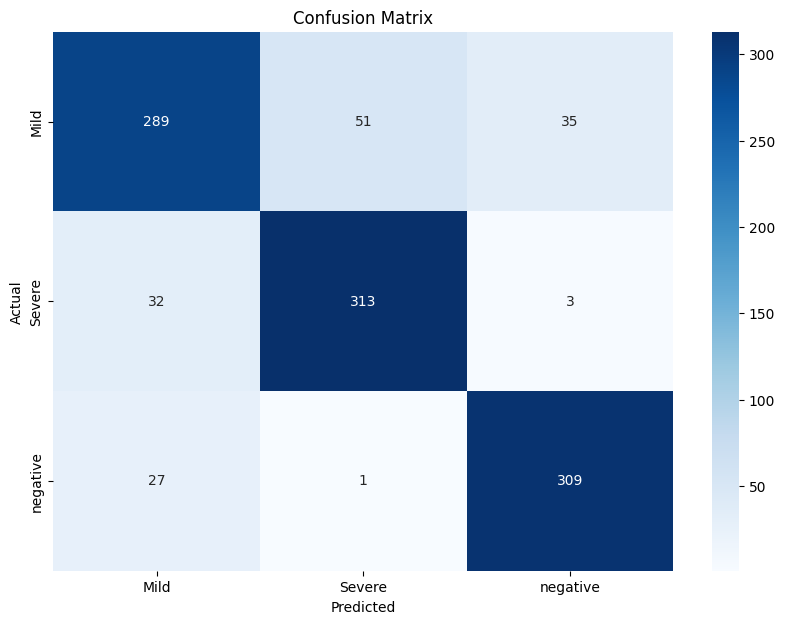

              precision    recall  f1-score   support

        Mild       0.83      0.77      0.80       375
      Severe       0.86      0.90      0.88       348
    negative       0.89      0.92      0.90       337

    accuracy                           0.86      1060
   macro avg       0.86      0.86      0.86      1060
weighted avg       0.86      0.86      0.86      1060



In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 혼동 행렬 그리기
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 리포트 출력
class_report = classification_report(targets, predictions, target_names=class_labels)
print(class_report)

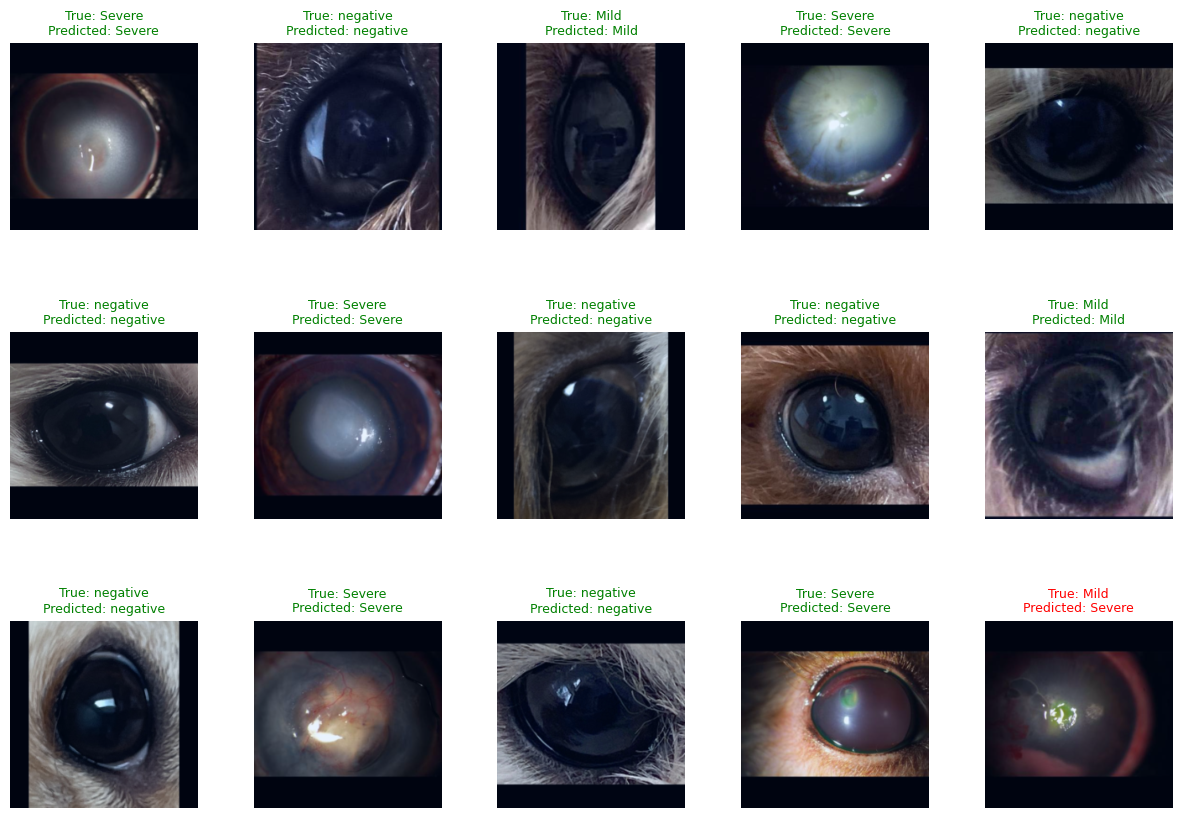

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

def visualize_batch(model, test_loader, device, class_names):
    model.eval()

    # 1배치 데이터 불러오기
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # 모델 예측
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # 이미지 시각화
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        img = utils.make_grid(inputs[i].cpu(), normalize=True).permute(1, 2, 0)
        ax.imshow(img)
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predicted[i].item()]

        # 정답과 예측이 일치하는지 확인하고 글씨 색상 결정
        if true_label == pred_label:
            color = 'green'
        else:
            color = 'red'

        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=9, color=color)
        ax.axis('off')

# 모델 예측 후의 1배치 이미지 시각화
visualize_batch(best_model, test_loader, device, class_labels)
